# Proyecto final - Minería de Datos
### Alejandro Carregha, Eduardo Don Pablo y José Salvador Abascal

## Descripción del Dataset

Una compañía de seguros médicos ha puesto a disposición un conjunto de datos que reúne información de aproximadamente 1,000 clientes. El objetivo principal de este dataset es permitir el desarrollo de un modelo predictivo capaz de estimar el costo anual del seguro médico (Price Premium of the insurance in USD) para cada cliente.

Es importante destacar que los datos han sido proporcionados de manera voluntaria por los clientes, lo que significa que la información reflejada en el conjunto es representativa de personas reales y sus condiciones de salud, permitiendo realizar análisis confiables y útiles para el diseño de modelos de riesgo, segmentación de clientes y optimización de precios.

### Variables del dataset:
- **Age**: Edad del cliente. Representa un factor crucial para las aseguradoras, ya que el riesgo médico suele aumentar con la edad.
- **Diabetes:**: Indica si la persona presenta niveles anormales de azúcar en la sangre. Este factor incrementa el riesgo y suele influir en un costo mayor del seguro debido a posibles complicaciones médicas.
- **BloodPressureProblems**: Señala si el individuo tiene problemas de presión arterial. La hipertensión es un factor de riesgo importante y comúnmente asociado a tratamientos médicos frecuentes.
- **AnyTransplants**: Indica si el cliente ha pasado por un trasplante de órgano mayor. Este tipo de procedimientos implica un historial médico de alto riesgo y puede incrementar significativamente el costo de la póliza.
- **AnyChronicDiseases**: Indica si el cliente padece alguna enfermedad crónica como asma, artritis, entre otras. Las condiciones crónicas suelen requerir tratamientos continuos, lo que impacta el cálculo del seguro.
- **Height**: Altura del cliente. Se usa principalmente junto con el peso para calcular indicadores como el índice de masa corporal (IMC), útil para identificar riesgo relacionado con sobrepeso u obesidad.
- **Weight**: Peso del cliente. Contribuye a estimar la condición física del individuo y evaluar riesgos asociados a hábitos de salud y posibles enfermedades.
- **KnownAllergies**: Señala si el cliente tiene alergias conocidas. Esto puede incluir alergias alimentarias, a medicamentos o ambientales, y aunque no siempre implica un alto riesgo, sí puede influir en el precio dependiendo de la severidad.
- **HistoryOfCancerInFamily**: Indica si algún familiar directo del cliente ha tenido algún tipo de cáncer. Un historial familiar positivo puede elevar la probabilidad de enfermedades hereditarias, lo cual es relevante para modelos de riesgo.
- **NumberOfMajorSurgeries**: Número de cirugías mayores que el cliente ha tenido. Un historial quirúrgico amplio suele estar asociado con mayores costos médicos y seguimiento especializado.

##### Variable objetivo:
- **PriceUSD**: Es la variable objetivo del dataset. Representa el precio anual del seguro médico en dólares estadounidenses para cada cliente, calculado en función de las variables anteriores.

### 1. Importar datos:

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [53]:
# Descargar y leer el dataset
data = pd.read_csv("Medicalpremium.csv")

print("Dataset cargado exitosamente!")
print(f"Dimensiones del dataset: {data.shape}")
print(f"Columnas: {data.columns.tolist()}")

Dataset cargado exitosamente!
Dimensiones del dataset: (986, 11)
Columnas: ['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice']


### 2. Análisis exploratorio de datos (EDA):

In [54]:
# Cambio de moneda (rupias a dólares)
data['PriceUSD'] = data['PremiumPrice']*0.011
del data['PremiumPrice']

# Primeras filas del dataset
data.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PriceUSD
0,45,0,0,0,0,155,57,0,0,0,275.0
1,60,1,0,0,0,180,73,0,0,0,319.0
2,36,1,1,0,0,158,59,0,0,1,253.0
3,52,1,1,0,1,183,93,0,0,2,308.0
4,38,0,0,0,1,166,88,0,0,1,253.0


In [55]:
# Información general del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      986 non-null    int64  
 1   Diabetes                 986 non-null    int64  
 2   BloodPressureProblems    986 non-null    int64  
 3   AnyTransplants           986 non-null    int64  
 4   AnyChronicDiseases       986 non-null    int64  
 5   Height                   986 non-null    int64  
 6   Weight                   986 non-null    int64  
 7   KnownAllergies           986 non-null    int64  
 8   HistoryOfCancerInFamily  986 non-null    int64  
 9   NumberOfMajorSurgeries   986 non-null    int64  
 10  PriceUSD                 986 non-null    float64
dtypes: float64(1), int64(10)
memory usage: 84.9 KB


In [56]:
# Estadísticas descriptivas
data.describe().round(2)

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PriceUSD
count,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00,986.00
mean,41.75,0.42,0.47,0.06,0.18,168.18,76.95,0.22,0.12,0.67,267.70
std,13.96,0.49,0.50,0.23,0.38,10.10,14.27,0.41,0.32,0.75,68.73
min,18.00,0.00,0.00,0.00,0.00,145.00,51.00,0.00,0.00,0.00,165.00
25%,30.00,0.00,0.00,0.00,0.00,161.00,67.00,0.00,0.00,0.00,231.00
50%,42.00,0.00,0.00,0.00,0.00,168.00,75.00,0.00,0.00,1.00,253.00
75%,53.00,1.00,1.00,0.00,0.00,176.00,87.00,0.00,0.00,1.00,308.00
max,66.00,1.00,1.00,1.00,1.00,188.00,132.00,1.00,1.00,3.00,440.00


In [57]:
# Verificar valores nulos
print("Valores nulos por columna:")
print(data.isnull().sum())

Valores nulos por columna:
Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PriceUSD                   0
dtype: int64


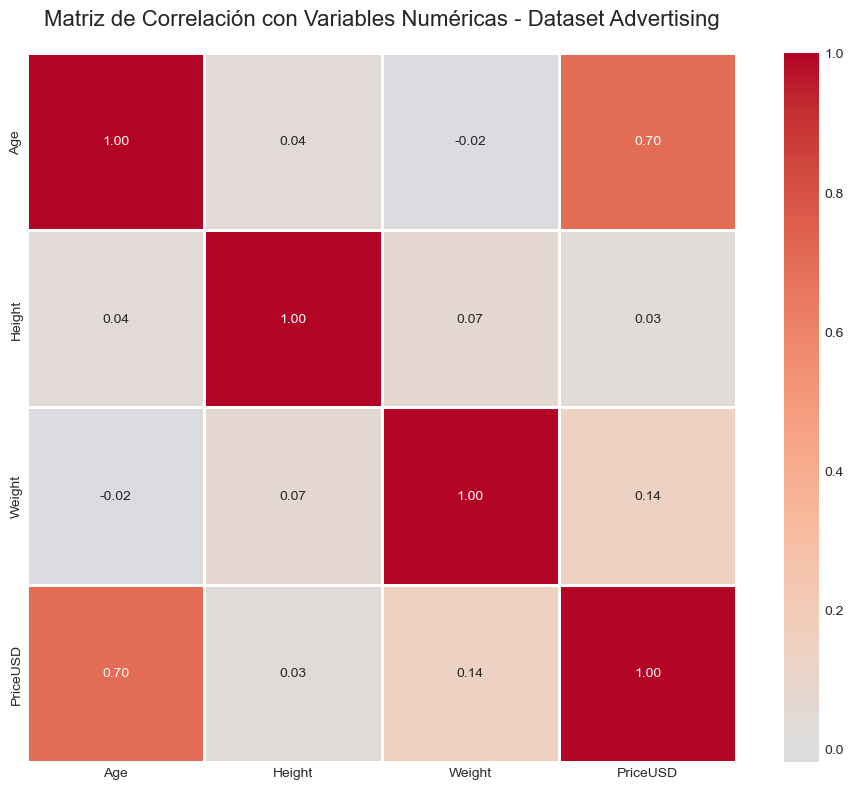

In [69]:
vars_num = data.loc[:,['Age','Height','Weight','PriceUSD']]
# Matriz de correlación con variables numéricas
correlation_matrix = vars_num.corr()
# Visualización de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Matriz de Correlación con Variables Numéricas - Dataset Advertising', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

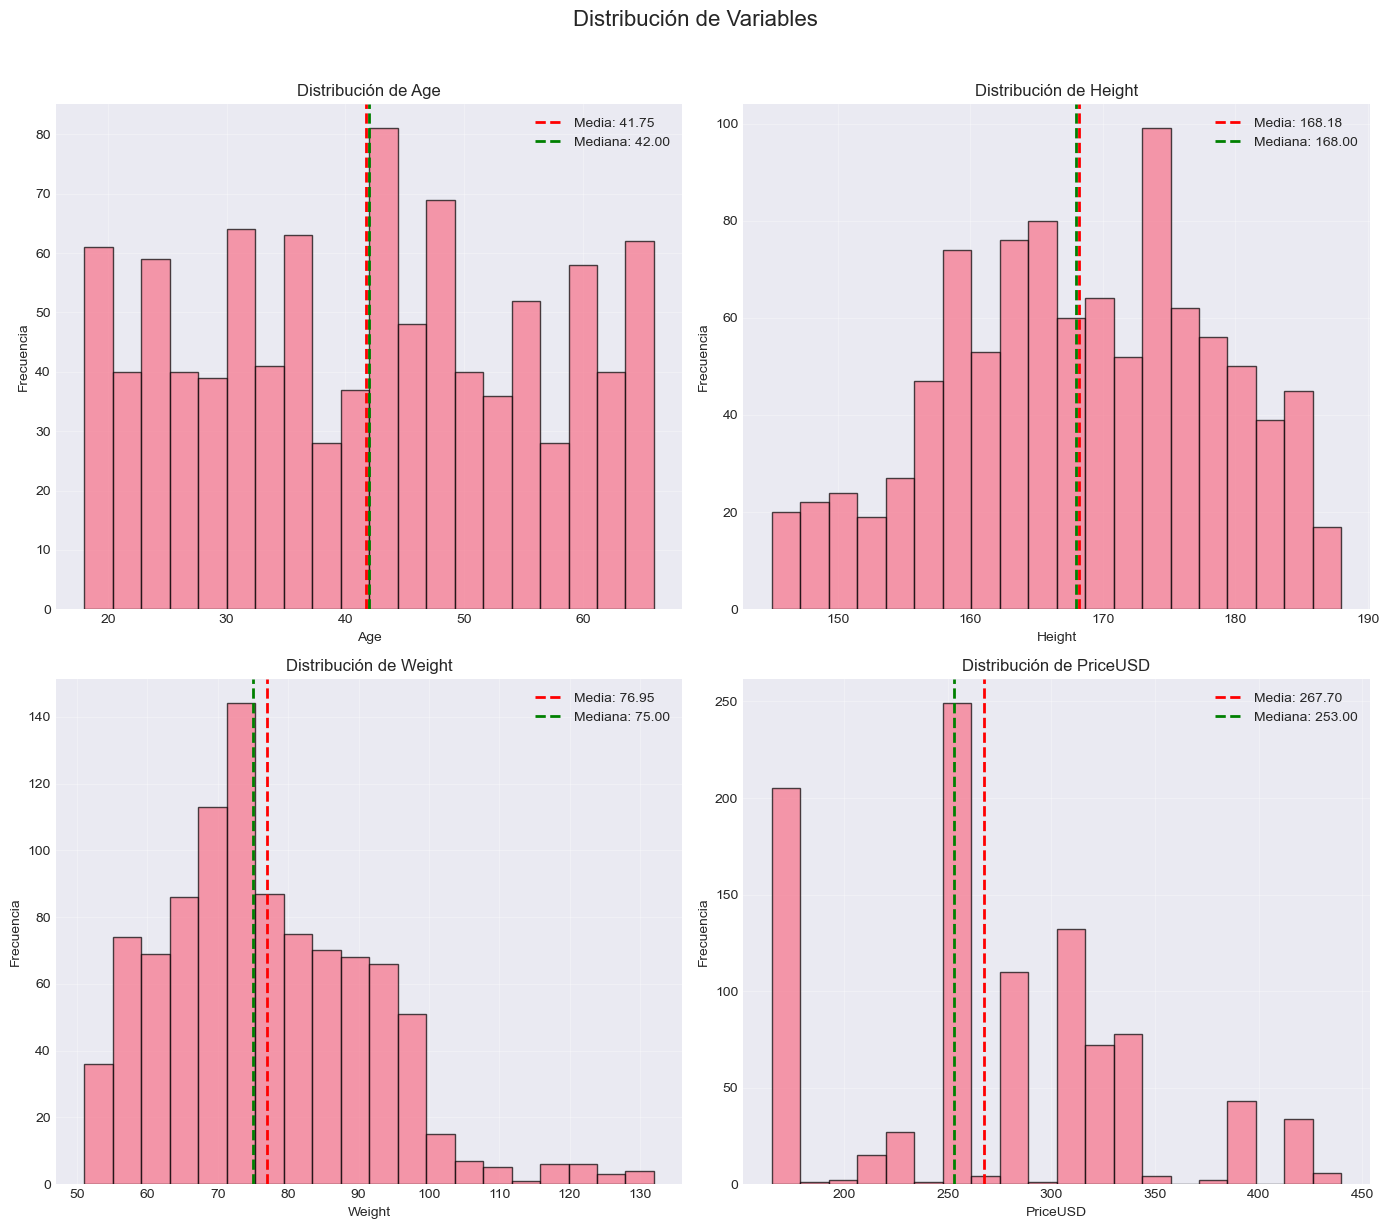

In [71]:
# Distribución de las variables
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Distribución de Variables', fontsize=16, y=1.02)

variables = vars_num

for idx, (ax, var) in enumerate(zip(axes.flat, variables)):
    ax.hist(data[var], bins=20, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribución de {var}', fontsize=12)
    ax.set_xlabel(var)
    ax.set_ylabel('Frecuencia')
    ax.grid(True, alpha=0.3)
    
    # Agregar estadísticas
    mean_val = data[var].mean()
    median_val = data[var].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

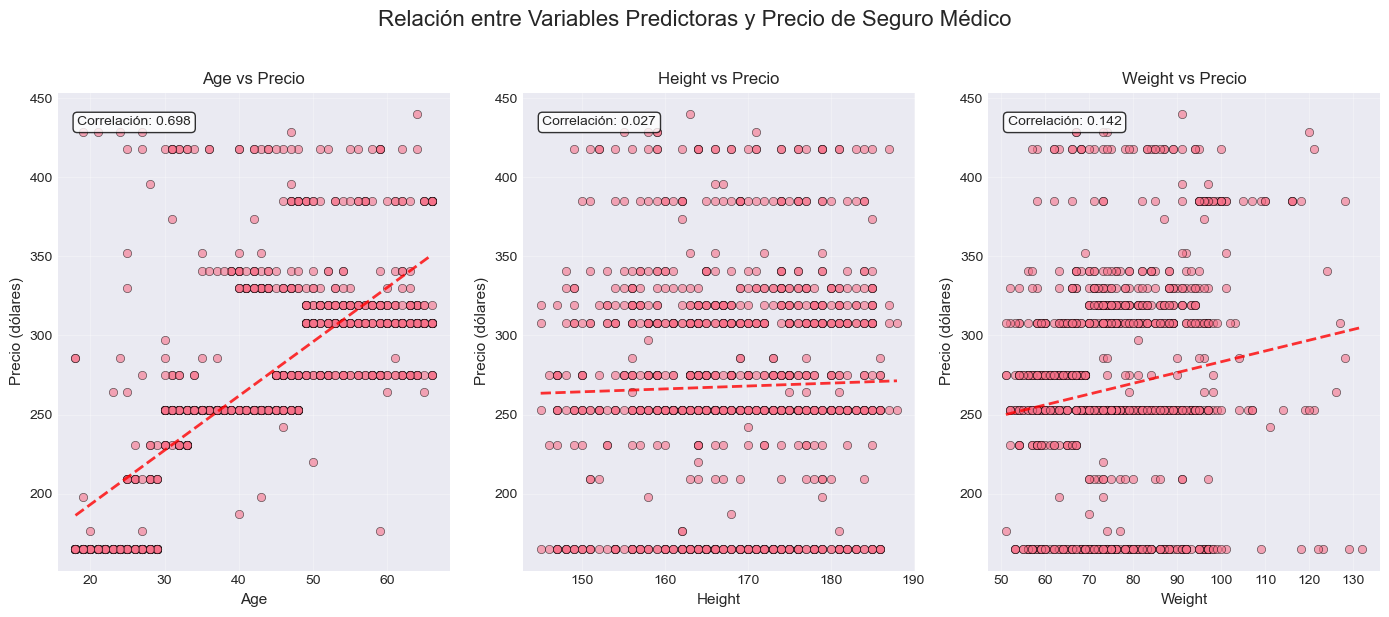

In [74]:
# Relación entre cada variable predictora y las ventas
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
fig.suptitle('Relación entre Variables Predictoras y Precio de Seguro Médico', fontsize=16, y=1.02)

predictors = vars_num
axes = axes.flatten()

for ax, predictor in zip(axes, predictors):
    ax.scatter(data[predictor], data['PriceUSD'], alpha=0.6, edgecolors='black', linewidth=0.5)
    ax.set_xlabel(f'{predictor}', fontsize=11)
    ax.set_ylabel('Precio (dólares)', fontsize=11)
    ax.set_title(f'{predictor} vs Precio', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Agregar línea de tendencia
    z = np.polyfit(data[predictor], data['PriceUSD'], 1)
    p = np.poly1d(z)
    ax.plot(data[predictor].sort_values(), p(data[predictor].sort_values()), 
            "r--", alpha=0.8, linewidth=2)
    
    # Agregar correlación
    corr = data[[predictor, 'PriceUSD']].corr().iloc[0, 1]
    ax.text(0.05, 0.95, f'Correlación: {corr:.3f}', transform=ax.transAxes, 
            fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

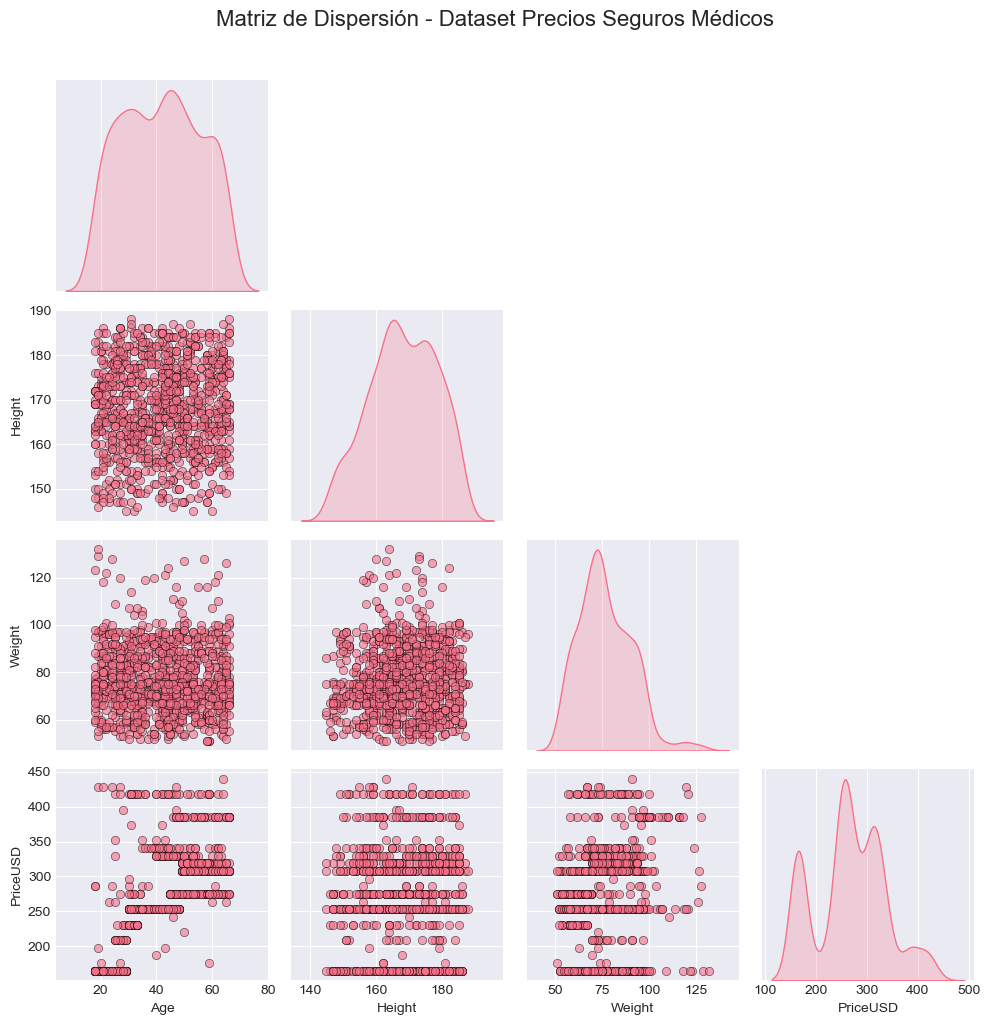

In [75]:
# Pairplot para visualizar todas las relaciones
plt.figure(figsize=(12, 10))
sns.pairplot(vars_num, diag_kind='kde', corner=True, 
             plot_kws={'alpha': 0.6, 'edgecolor': 'black', 'linewidth': 0.5})
plt.suptitle('Matriz de Dispersión - Dataset Precios Seguros Médicos', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()